# Analyzing Witness Networks

[David J. Thomas](mailto:dave.a.base@gmail.com), [thePortus.com](http://thePortus.com)<br />
Instructor of Ancient History and Digital Humanities,<br />
Department of History,<br />
[University of South Florida](https://github.com/usf-portal)

---

## This workbook will...

* Use the `networkx` module to analyze witnesses in the charters
* Calculate network statistics like degree, betweeness centrality, community detection, and more
* Export the network with statistics for use elsewhere in programs like Gephi
* Visualize the network as a whole and in parts
* Attempt to identify major figures at different levels of the network


---

## 1) Import Module Dependencies

The cell below loads all other Python packages needed. You **must** run this before any other cells.

In [19]:
from IPython.core.display import display, HTML
import sqlalchemy as sql
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import networkx as nx
import community
import matplotlib.pyplot as plt
import dhelp

## 2) (Re)declare Database Models

In [20]:
engine = sql.create_engine('sqlite:///charters.db', echo=False)
Base = declarative_base()
    

class Charter(Base):
    __tablename__ = 'charters'

    id = sql.Column(sql.String, primary_key=True)
    description = sql.Column(sql.String)
    sawyer = sql.Column(sql.Integer)
    birch = sql.Column(sql.Integer)
    kemble = sql.Column(sql.Integer)
    british_academy = sql.Column(sql.String)
    source_used = sql.Column(sql.String)
    archive = sql.Column(sql.String)
    language = sql.Column(sql.String)
    date = sql.Column(sql.Integer)
    scholarly_date = sql.Column(sql.String)
    scholarly_date_low = sql.Column(sql.Integer)
    scholarly_date_high = sql.Column(sql.Integer)
    scholarly_date_avg = sql.Column(sql.Float)
    text = sql.Column(sql.Text)
    notes = sql.Column(sql.Text)
    asc_source = sql.Column(sql.String)
    pase_source = sql.Column(sql.String)
    pase_witnesses = sql.Column(sql.String)
    
    witnesses = sql.orm.relationship('Person', secondary='charter_witnesses', back_populates='charters')
    
    @property
    def record(self):
        """Gets entry data in dictionary format."""
        return {
            'id': self.id,
            'label': self.id,
            'sawyer': self.sawyer,
            'birch': self.birch,
            'kemble': self.kemble,
            'british_academy': self.british_academy,
            'source_used': self.source_used,
            'archive': self.archive,
            'language': self.language,
            'date': self.date,
            'scholarly_date': self.scholarly_date,
            'scholarly_date_low': self.scholarly_date_low,
            'scholarly_date_high': self.scholarly_date_high,
            'scholarly_date_avg': self.scholarly_date_avg,
            'text': self.text,
            'notes': self.notes,
            'asc_source': self.asc_source,
            'pase_source': self.pase_source,
            'pase_witnesses': self.pase_witnesses
        }
    
    def num_common_witnesses(self, other_charter):
        """Checks self and other_charter for the number of witnesses that appear in both charters."""
        total_counter = 0
        for witness in self.witnesses:
            for other_witness in other_person.witnesses:
                if witness.id == other_witness.id:
                    total_counter += 1
        return total_counter
                    
    
class Person(Base):
    __tablename__ = 'people'
    
    id = sql.Column(sql.String, primary_key=True)
    description = sql.Column(sql.String)
    link = sql.Column(sql.String)
    
    charters = sql.orm.relationship('Charter', secondary='charter_witnesses', back_populates='witnesses')
    
    @property
    def record(self):
        """Gets entry data in dictionary format."""
        return {
            'id': self.id,
            'label': self.id + ': ' + self.description,
            'link': self.link
        }
    
    @property
    def earliest_appearance(self):
        """Returns the date of the earliest charter features said person."""
        earliest_charter = None
        for charter in self.charters:
            if not earliest_charter:
                earliest_charter = charter.scholarly_date_avg
            else:
                if charter.scholarly_date_avg < earliest_charter:
                    earliest_charter = charter.scholarly_date_avg
        return earliest_charter
    
    def num_coappearances(self, other_person):
        """Checks the number of times this person appears in the same charters as other_person"""
        total_counter = 0
        for charter in self.charters:
            for other_charter in other_person.charters:
                if charter.id == other_charter.id:
                    total_counter += 1
        return total_counter

    
class CharterWitness(Base):
    __tablename__ = 'charter_witnesses'
    charter_id = sql.Column(sql.String, sql.ForeignKey('charters.id'), primary_key=True) 
    person_id = sql.Column(sql.String, sql.ForeignKey('people.id'), primary_key=True)
    role = sql.Column(sql.String)
    link = sql.Column(sql.String)
    
    @property
    def record(self):
        """Gets entry data in dictionary format."""
        return {
            'charter_id': self.charter_id,
            'person_id': self.person_id,
            'label': self.role,
            'link': self.link
        }


print('Database Configured Successfully')

Database Configured Successfully


# 3) Build Co-Appearing Witness Graph

In [21]:
# first we need to open a session with the local database, get every witness, then close the connection
session = sessionmaker(bind=engine)()
witnesses = session.query(Person)
session.close()

print('Building network graph...', end='')
# create an empty networkx graph
witness_network = nx.Graph(
    label='',
    link=None,
    weight=1,
    type='Undirected',
    community=None,
    degree=0,
    degree_centrality=0,
    betweeness_centrality=0,
    eigenvector_centrality=0,
    closeness_centrality=0,
    harmonic_centrality=0,
)

# populate the nodes with each witness record
for person in witnesses:
    witness_network.add_node(person.id, **person.record)

counter = 0
# to build edges, we need to compare every witness against each other for the number of times they appear
for index, person in enumerate(witnesses):
    for other_person in witnesses[index + 1:]:
        counter += 1
        if counter % 50000 == 0:
            print('.', end='')
        num_coappearances = person.num_coappearances(other_person)
        # only add an edge if they actually appeared together
        if num_coappearances > 0:
            witness_network.add_edge(
                person.id,
                other_person.id,
                label='{} -> {}'.format(person.id, other_person.id),
                weight=person.num_coappearances(other_person),
                type='Undirected'
            )

print('\n\nFinished.')

Building network graph........................................

Finished.


# 4) Crunch Network Statistics and Export Graph

In [22]:
def crunch_network(network):
    print('Crunching various network statistics (takes awhile)...\n')
    results = {
        'degree': {}, 'community': {}, 'degree_centrality': {}, 'betweeness_centrality': {},
        'eigenvector_centrality': {}, 'closeness_centrality': {}, 'harmonic_centrality': {}
    }
    # degrees and community
    print('Degrees...', end='')
    results['degree'] = nx.degree(witness_network)
    print(' Done!\nCommunity detection with best partition...', end='')
    results['community'] = community.best_partition(witness_network)
    # centralities
    print(' Done!\nDegree centrality...', end='')
    results['degree_centrality'] = nx.degree_centrality(witness_network)
    print(' Done!\nBetweeness (shortest-path) centrality...', end='')
    results['betweeness_centrality'] = nx.betweenness_centrality(witness_network)
    print(' Done!\nEigenvector centrality...', end='')
    results['eigenvector_centrality'] = dict(nx.eigenvector_centrality(witness_network))
    print(' Done!\nCloseness centrality...', end='')
    results['closeness_centrality'] = nx.closeness_centrality(witness_network)
    print(' Done!\nHarmonic centrality...', end='')
    results['harmonic_centrality'] =  nx.harmonic_centrality(witness_network)
    print(' Done!\n\nFinished calculating network statistics.')
    # now take result dicts and feed them back into nodes as attributes
    for attribute_name in results.keys():
        attribute_results = results[attribute_name]
        for node_id in network.nodes():
            new_node_stat = attribute_results[node_id]
            network.nodes[node_id][attribute_name] = new_node_stat
    return network


witness_network = crunch_network(witness_network)
print('Exporting network with calculated statistics to export/witness_network.gexf')
nx.write_gexf(witness_network, '../export/witness_network.gexf')
print('Exported network successfully.')

Crunching various network statistics (takes awhile)...

Degrees... Done!
Community detection with best partition... Done!
Degree centrality... Done!
Betweeness (shortest-path) centrality... Done!
Eigenvector centrality... Done!
Closeness centrality... Done!
Harmonic centrality... Done!

Finished calculating network statistics.
Exporting network with calculated statistics to export/witness_network.gexf
Exported network successfully.


## 5) Visualize Entire Witness Network

Entire Witness Network
Generating network preview...


True

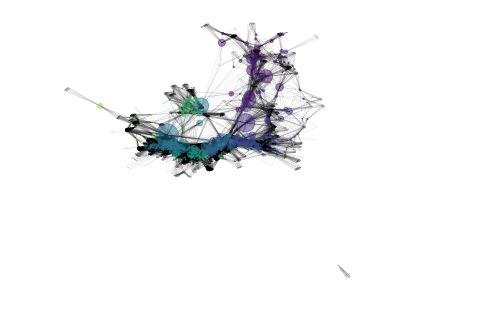

In [33]:
def draw_network(network, with_labels=False):
    node_size_map = [network.nodes[node]['betweeness_centrality'] * 3000 for node in network.nodes()]
    node_color_map = [network.nodes[node]['community'] for node in network.nodes()]
    options = {
        'node_color': node_color_map,
        'node_size': node_size_map,
        'width': 0.1,
        'alpha': 0.5,
        'with_labels': with_labels
    }
    print('Generating network preview...')
    nx.draw(network, pos=nx.spring_layout(network, k=0.05, scale=1), **options)
    plt.draw()
    return True


print('Entire Witness Network')
draw_network(witness_network)

## 6) Finding Key Figures

### 6a) Listing Top People by Attributes

In [24]:
def order_nodes_by_attribute(network, attribute_name):
    totals = {}
    # build a key/val dict from id/val of node
    for node in network.nodes():
        totals[node] = network.nodes[node][attribute_name]
    # sort into ordered list of tuples with id/val and return
    return [(key, totals[key]) for key in sorted(totals, key=totals.get, reverse=True)]


def print_top_nodes_by_attribute(network, attribute_name, print_name, limit=5):
    print('----- {} -----'.format(print_name))
    counter = 0
    for node_id, val in order_nodes_by_attribute(network, attribute_name)[0:4]:
        counter += 1
        node_link = network.nodes[node_id]['link']
        print('{}.) {}: {}'.format(counter, node_id, node_link, val))


attributes_to_print = [
    ('degree', 'Degree'),
    ('betweeness_centrality', 'Betweeness Centrality'),
    ('degree_centrality', 'Degree Centrality'),
    ('closeness_centrality', 'Closeness Centrality'),
    ('eigenvector_centrality', 'Eigenvector Centrality'),
    ('harmonic_centrality', 'Harmonic Centrality')
]

for attribute_name, print_name in attributes_to_print:
    print_top_nodes_by_attribute(witness_network, attribute_name, print_name)
    print('')

----- Degree -----
1.) Wulfred 6: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=2603
2.) Eadwulf 7: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=3652
3.) Ceolnoth 3: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=242
4.) Alfred 8: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=17

----- Betweeness Centrality -----
1.) Alfred 8: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=17
2.) Æthelbald 4: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=1324
3.) Cenwealh 2: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=14054
4.) Offa 7: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=305

----- Degree Centrality -----
1.) Wulfred 6: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=2603
2.) Eadwulf 7: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=3652
3.) Ceolnoth 3: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=242
4.) Alfred 8: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=17

----- Closeness Centrality -----
1.

### 6b) Looking into Individuals

In [7]:
def lookup_person(network, node_id):
    link = network.nodes[node_id]['link']
    pase_content = None
    with dhelp.WebPage(link) as page_soup:
        pase_content = page_soup
    display(HTML(pase_content.get_text()))
    return pase_content

notable_persons = ['Alfred 8', 'Wulfred 6', 'Eadwulf 7', 'Ceolnoth 3', 'Æthelbald 4', 'Cenwealh 2', 'Offa 7']

for notable_person in notable_persons:
    print('---', notable_person)
    lookup_person(witness_network, notable_person)

print('Finished displaying persons')

--- Alfred 8
Fetching http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=17
Successfully scraped http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=17


--- Wulfred 6
Fetching http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=2603
Successfully scraped http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=2603


--- Eadwulf 7
Fetching http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=3652
Successfully scraped http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=3652


--- Ceolnoth 3
Fetching http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=242
Successfully scraped http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=242


--- Æthelbald 4
Fetching http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=1324
Successfully scraped http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=1324


--- Cenwealh 2
Fetching http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=14054
Successfully scraped http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=14054


--- Offa 7
Fetching http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=305
Successfully scraped http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=305


Finished displaying persons


### 8) Looking into Sub-Communities

Alfred the Great
Crunching various network statistics (takes awhile)...

Degrees... Done!
Community detection with best partition... Done!
Degree centrality... Done!
Betweeness (shortest-path) centrality... Done!
Eigenvector centrality... Done!
Closeness centrality... Done!
Harmonic centrality... Done!

Finished calculating network statistics.
Generating network preview...
----- Degree -----
1.) Ceolnoth 3: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=242
2.) Alfred 8: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=17
3.) Ealhstan 3: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=262
4.) Æthelwulf 1: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=15

----- Betweeness Centrality -----
1.) Alfred 8: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=17
2.) Cenwealh 2: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=14054
3.) Ealhstan 3: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=262
4.) Ceolnoth 3: http://www.pase.ac.uk/jsp/DisplayPerson.

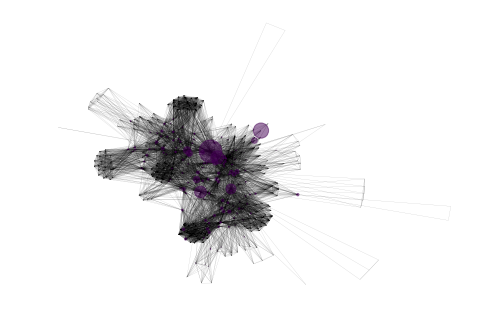

In [34]:
def get_community(network, community_num):
    """Returns a new network with only nodes/edges from a specified community"""
    non_community_nodes = []
    # perform full copy of network
    subnetwork = network.copy()
    # identify only the nodes to be keps
    for node_id in subnetwork.nodes():
        if subnetwork.nodes[node_id]['community'] != community_num:
            non_community_nodes.append(node_id)
    subnetwork.remove_nodes_from(non_community_nodes)
    # make new subgraph with select nodes and crunch new stats
    return crunch_network(subnetwork)


print('Alfred the Great')
alfred_community = get_community(witness_network, witness_network.nodes['Alfred 8']['community'])
draw_network(alfred_community)

for attribute_name, print_name in attributes_to_print:
    print_top_nodes_by_attribute(alfred_community, attribute_name, print_name)
    print('')

Offa of Mercia
Crunching various network statistics (takes awhile)...

Degrees... Done!
Community detection with best partition... Done!
Degree centrality... Done!
Betweeness (shortest-path) centrality... Done!
Eigenvector centrality... Done!
Closeness centrality... Done!
Harmonic centrality... Done!

Finished calculating network statistics.
Generating network preview...
----- Degree -----
1.) Offa 7: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=305
2.) Æthelheard 13: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=2121
3.) Wihthun 2: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=14403
4.) Ealhheard 1: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=13550

----- Betweeness Centrality -----
1.) Offa 7: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=305
2.) Wærmund 6: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=5541
3.) Brorda 2: http://www.pase.ac.uk/jsp/DisplayPerson.jsp?personKey=4390
4.) Jænberht 1: http://www.pase.ac.uk/jsp/DisplayPerson

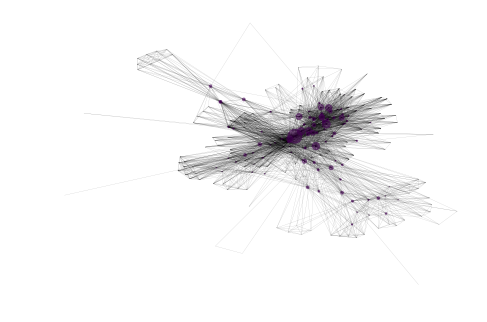

In [32]:
print('Offa of Mercia')
offa_community = get_community(witness_network, witness_network.nodes['Offa 7']['community'])
draw_network(offa_community, with_labels=True)

for attribute_name, print_name in attributes_to_print:
    print_top_nodes_by_attribute(offa_community, attribute_name, print_name)
    print('')